<a href="https://colab.research.google.com/github/KenzaB27/segmentation-of-pelvic-bone/blob/main/src/inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [1]:
!nvidia-smi

Wed May 26 18:22:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/KenzaB27/segmentation-of-pelvic-bone.git
%cd /content/segmentation-of-pelvic-bone/src

In [ ]:
!pip install SimpleITK

In [23]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/KenzaB27/segmentation-of-pelvic-bone
   90a7be2..27fc0db  main       -> origin/main
Updating 90a7be2..27fc0db
Fast-forward
 src/analysis.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)


In [6]:
import sys
sys.path.append('../src/')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import SimpleITK as sitk
import analysis as ana
import numpy as np 
import importlib

import tensorflow as tf 
tfk = tf.keras
tfkl = tfk.layers

In [8]:
PATH = "/content/drive/My Drive/KTH/HL2027/"
DATA_PATH = PATH +'data/'

## Load Data

In [24]:
%%time
importlib.reload(ana)
data = ana.PelvicData(root_path=PATH)

CPU times: user 12.3 s, sys: 1.58 s, total: 13.9 s
Wall time: 13.9 s


In [32]:
data.cmn_img_3c[42].shape

(291, 512, 512, 3)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(data.X_train_3C, data.y_train, test_size=0.10, random_state=42, stratify=data.y_train)
print(f"X train shape:{X_train.shape}, y train shape:{y_train.shape} ")
print(f"X val shape:{X_val.shape}, y val shape:{y_val.shape} ")

X train shape:(729, 512, 512, 3), y train shape:(729,) 
X val shape:(129, 512, 512, 3), y val shape:(129,) 


## Inception V3 

In [79]:
input = tfkl.Input([None, None, 3], dtype = tf.int16)
x = tf.cast(input, tf.float32)
x = tfk.applications.inception_v3.preprocess_input(x)
inception_model = tfk.applications.InceptionV3(weights="imagenet", include_top=False, pooling="max")
inception_output = inception_model(x)
hidden_layer = tfkl.Dense(128, activation='relu')(inception_output)
hl_reg = tfkl.Dropout(0.2)(hidden_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hl_reg)
model = tf.keras.models.Model(inputs=input, outputs=output_layer)

In [80]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
tf.cast_8 (TFOpLambda)       (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv_8 (TFOpLambd (None, None, None, 3)     0         
_________________________________________________________________
tf.math.subtract_8 (TFOpLamb (None, None, None, 3)     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_16 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0   

### Training 

In [81]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
inception_model.trainable = False
for layer in inception_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', 
              metrics=['acc'])

In [82]:
checkpoint_filepath = PATH + '/checkpoint/inception/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
history = model.fit(x=X_train, y=y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/50
23/23 [==============================] - 10s 276ms/step - loss: 2.8158 - acc: 0.7737 - val_loss: 0.5370 - val_acc: 0.8837
Epoch 2/50
23/23 [==============================] - 5s 228ms/step - loss: 1.0684 - acc: 0.8272 - val_loss: 0.2826 - val_acc: 0.8992
Epoch 3/50
23/23 [==============================] - 5s 228ms/step - loss: 0.5889 - acc: 0.8354 - val_loss: 0.1422 - val_acc: 0.9302
Epoch 4/50
23/23 [==============================] - 5s 228ms/step - loss: 0.4604 - acc: 0.8656 - val_loss: 0.2362 - val_acc: 0.9147
Epoch 5/50
23/23 [==============================] - 5s 228ms/step - loss: 0.3686 - acc: 0.8642 - val_loss: 0.0993 - val_acc: 0.9535
Epoch 6/50
23/23 [==============================] - 5s 228ms/step - loss: 0.3007 - acc: 0.8793 - val_loss: 0.1517 - val_acc: 0.8837
Epoch 7/50
23/23 [==============================] - 5s 227ms/step - loss: 0.2591 - acc: 0.8930 - val_loss: 0.1073 - val_acc: 0.9612
Epoch 8/50
23/23 [==============================] - 5s 228ms/step - loss: 0

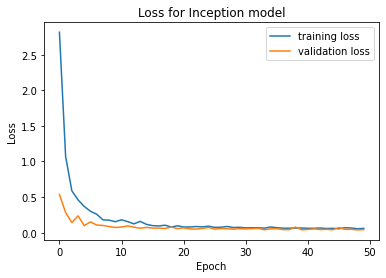

In [83]:
plt.figure()
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("Loss for Inception model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

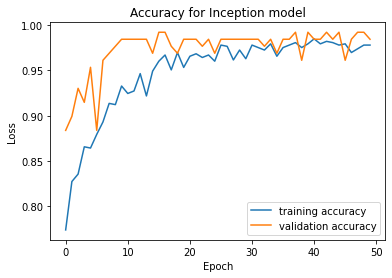

In [84]:
plt.figure()
plt.plot(history.history["acc"], label="training accuracy")
plt.plot(history.history["val_acc"], label="validation accuracy")
plt.title("Accuracy for Inception model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test Performance on Common Images

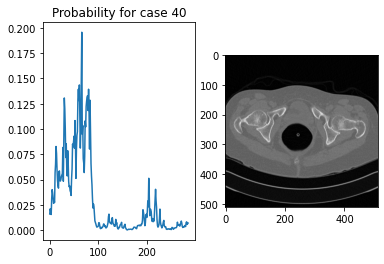

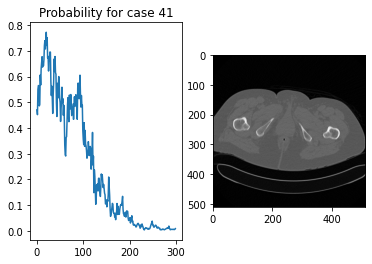

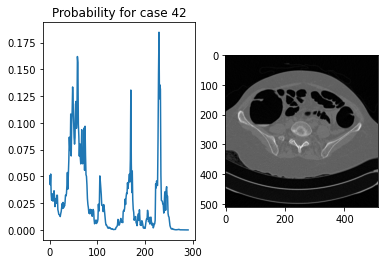

CPU times: user 7.41 s, sys: 13.5 ms, total: 7.43 s
Wall time: 6.87 s


In [85]:
%%time
for id, cmn_img in data.cmn_img_3c.items():
  y_pred = model.predict(cmn_img)
  argmax = np.argmax(y_pred)
  plt.figure()
  
  plt.subplot(121)
  plt.plot(y_pred)
  plt.title(f"Probability for case {id}")

  plt.subplot(122)
  plt.imshow(data.cmn_img[id][argmax], cmap="gray")
  plt.show()